In [311]:
import os.path as path
import pandas as pd
import urllib
import zipfile
import sys
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib.mlab as mlab
import glob

from scipy.stats.kde import gaussian_kde
%matplotlib inline

from statsmodels.nonparametric.kde import KDEUnivariate

#import statsmodels.api as sm
from sklearn import linear_model, preprocessing
from sklearn.preprocessing import StandardScaler

## Densité

### Spécialistes

In [312]:
# densité de medecins par region
xl = pd.ExcelFile("Effectif_et_densite_par_region_en_2014.xls")
#print(xl.sheet_names)

df_spe_densite = xl.parse("Spécialistes")
#df_spe_densite.head()

### Généralistes

In [313]:
df_gen_densite = xl.parse("Généralistes et MEP")
#df_gen_densite.head()

## Honoraires

In [314]:
# lecture du fichier
# Honoraires_totaux_des_professionnels_de_sante_par_region_en_2014
xl = pd.ExcelFile("Honoraires_totaux_des_professionnels_de_sante_par_region_en_2014.xls")
print(xl.sheet_names)

['Lisez moi', 'Nomenclature des PS', 'Spécialistes', 'Généralistes et MEP', 'Dentistes et ODF', 'Sages-femmes', 'Auxiliaires médicaux', 'Laboratoires']


### Spécialistes

In [331]:
# nettoyage des "spécialistes"

df_spe_hono = xl.parse("Spécialistes")
df_spe_hono.head()
#print(df_spe_hono.columns)

# typer les colonnes
df_spe_hono.dtypes
df_spe_hono[['HONORAIRES SANS DEPASSEMENT (Euros)','DEPASSEMENTS (Euros)']] = \
    df_spe_hono[['HONORAIRES SANS DEPASSEMENT (Euros)','DEPASSEMENTS (Euros)']].apply(pd.to_numeric, errors='coerce')
#df_spe_hono.dtypes

# remplacer les NaN par 0, dans les colonnes numériques
df_spe_hono[['HONORAIRES SANS DEPASSEMENT (Euros)','DEPASSEMENTS (Euros)']] = \
    df_spe_hono[['HONORAIRES SANS DEPASSEMENT (Euros)','DEPASSEMENTS (Euros)']].fillna(value=0)

# supprimer les lignes 'TOTAL'
specialiste_slicer = df_spe_hono['Spécialistes'].str.upper().str.contains('TOTAL')
region_slicer = df_spe_hono['REGION INSEE'].str.upper().str.contains('TOTAL')
df_spe_hono = df_spe_hono[~specialiste_slicer & ~region_slicer]

print(df_spe_hono['Spécialistes'].unique())
print(df_spe_hono['REGION INSEE'].unique())

['02- Anesthésie-réanimation chirurgicale' '20- Réanimation médicale'
 '03- Pathologie cardio-vasculaire' '43- Chirurgie infantile'
 '44- Chirurgie maxillo-faciale'
 '46- Chirurgie plastique reconstructrice et esthétique'
 '47- Chirurgie thoracique et cardio-vasculaire' '48- Chirurgie vasculaire'
 '49- Chirurgie viscérale et digestive' '04- Chirurgie générale'
 '10- Neurochirurgie' '16- Chirurgie urologique'
 '41- Chirurgie orthopédique et traumatologie' '05- Dermato-vénéréologie'
 '72- Médecine nucléaire' '74- Oncologie radiothérapique'
 '76- Radiothérapie' '06- Radiodiagnostic et imagerie médicale'
 '70- Gynécologie médicale' '77- Obstétrique'
 '79- Gynécologie obstétrique et gynécologie médicale'
 '07- Gynécologie obstétrique' '08- Gastro-entérologie et hépatologie'
 '71- Hématologie' '73- Oncologie médicale' '09- Médecine interne'
 '11- Oto-rhino-laryngologie' '78- Médecine génétique' '12- Pédiatrie'
 '13- Pneumologie' '14- Rhumatologie' '15- Ophtalmologie'
 '45- Chirurgie maxillo-

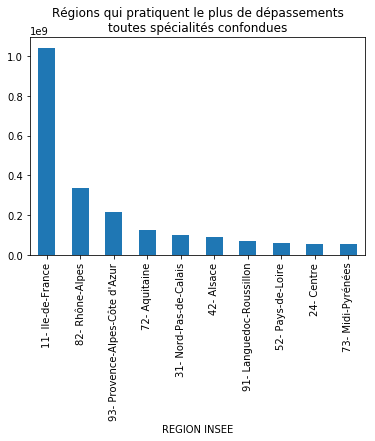

In [323]:
# dépassemnts par specialiste et région
# On plot les régions qui pratiquent le plus de dépassement, toutes spécialités confondues
# on regardera ensuite, pour chacune des trois premières régions, quelles sont les spéciélités
# qui pratiquent le plus de dépassements

depBySpeAndReg = df_spe_hono.groupby(['Spécialistes','REGION INSEE'])['DEPASSEMENTS (Euros)'].sum()   
depBySpe = df_spe_hono.groupby(['Spécialistes'])['DEPASSEMENTS (Euros)'].sum()   
#depBySpe[depBySpe != 0].plot.pie()

depByReg = df_spe_hono.groupby(['REGION INSEE'])['DEPASSEMENTS (Euros)'].sum()   
depByReg.sort_values(inplace=True, ascending=False)
depByReg[depByReg != 0][:10].plot.bar(title='Régions qui pratiquent le plus de \
    dépassements\ntoutes spécialités confondues')

** Ile de France : **

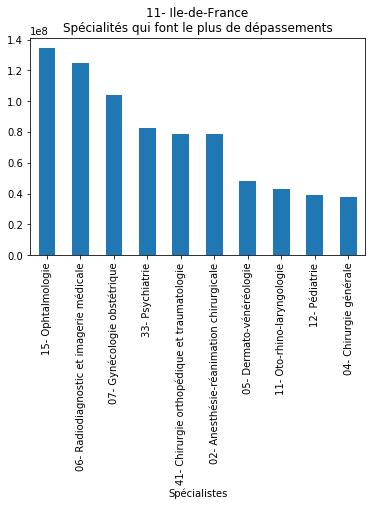

In [317]:
#Ile de France, plot first ten specialities 
region = '11- Ile-de-France'
dep_IDF = df_spe_hono[df_spe_hono['REGION INSEE']==region]
depBySpeIDF = dep_IDF.groupby(['Spécialistes'])['DEPASSEMENTS (Euros)'].sum()
depBySpeIDF.sort_values(inplace=True, ascending=False)
depBySpeIDF[depBySpeIDF != 0][:10].plot.bar(title=region+'\nSpécialités qui font \
    le plus de dépassements')

** Rhône Alpes : **

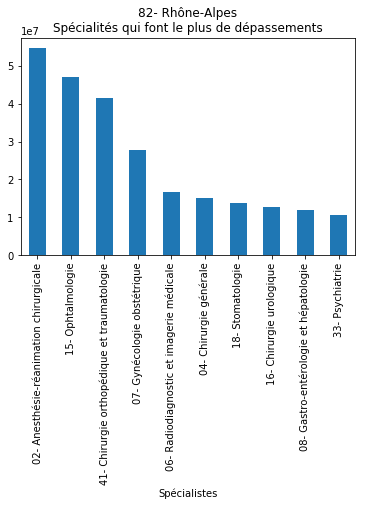

In [318]:
# Rhone Alpes, plot first ten specialities 
region = '82- Rhône-Alpes'
dep_RA = df_spe_hono[df_spe_hono['REGION INSEE']==region]
depBySpeRA = dep_RA.groupby(['Spécialistes'])['DEPASSEMENTS (Euros)'].sum()
depBySpeRA.sort_values(inplace=True, ascending=False)
depBySpeRA[depBySpeRA != 0][:10].plot.bar(title=region+'\nSpécialités qui font \
    le plus de dépassements')

** PACA : **

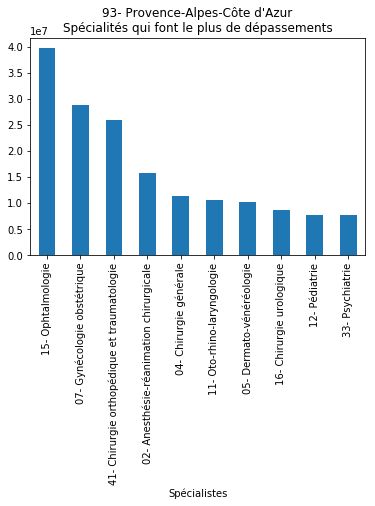

In [319]:
# PACA plot 10 first specialities
region = "93- Provence-Alpes-Côte d'Azur"
dep_P = df_spe_hono[df_spe_hono['REGION INSEE']==region]
depBySpeP = dep_P.groupby(['Spécialistes'])['DEPASSEMENTS (Euros)'].sum()
depBySpeP.sort_values(inplace=True, ascending=False)
depBySpeP[depBySpeP != 0][:10].plot.bar(title=region+'\nSpécialités qui font \
    le plus de dépassements')

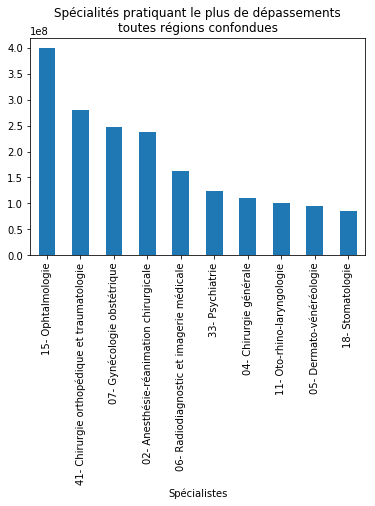

In [326]:
# Spécialités pratiquant le plus de dépassements, toutes régions confondues
depBySpe = df_spe_hono.groupby(['Spécialistes'])['DEPASSEMENTS (Euros)'].sum()   
depBySpe.sort_values(inplace=True, ascending=False)
depBySpe[depBySpe != 0][:10].plot.bar(title='Spécialités pratiquant le plus de \
    dépassements\ntoutes régions confondues')

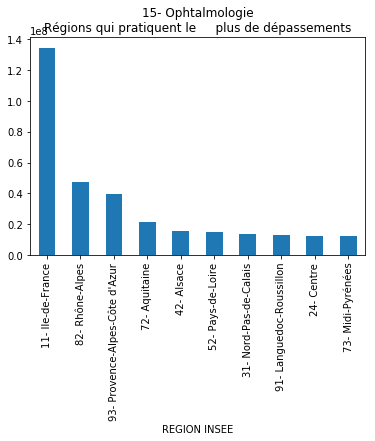

In [327]:
# Ophtalmo plot 10 first regions
spec = "15- Ophtalmologie"
dep_P = df_spe_hono[df_spe_hono['Spécialistes']==spec]
depBySpeP = dep_P.groupby(['REGION INSEE'])['DEPASSEMENTS (Euros)'].sum()
depBySpeP.sort_values(inplace=True, ascending=False)
depBySpeP[depBySpeP != 0][:10].plot.bar(title=spec+'\nRégions qui pratiquent le \
    plus de dépassements')

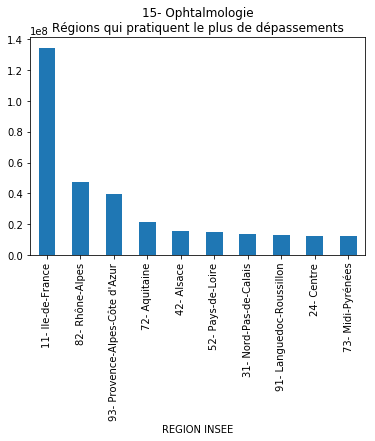

In [333]:
# Ophtalmo plot 10 first regions
spec = "15- Ophtalmologie"
dep_P = df_spe_hono[df_spe_hono['Spécialistes']==spec]
depBySpeP = dep_P.groupby(['REGION INSEE'])['DEPASSEMENTS (Euros)'].sum()
depBySpeP.sort_values(inplace=True, ascending=False)
depBySpeP[depBySpeP != 0][:10].plot.bar(title=spec+'\nRégions qui pratiquent le plus de dépassements')

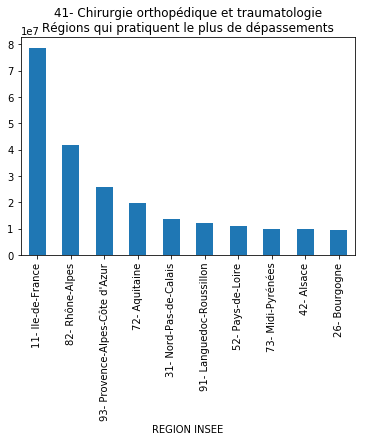

In [332]:
# 41- Chirurgie orthopédique et traumatologie
spec = "41- Chirurgie orthopédique et traumatologie"
dep_P = df_spe_hono[df_spe_hono['Spécialistes']==spec]
depBySpeP = dep_P.groupby(['REGION INSEE'])['DEPASSEMENTS (Euros)'].sum()
depBySpeP.sort_values(inplace=True, ascending=False)
depBySpeP[depBySpeP != 0][:10].plot.bar(title=spec+'\nRégions qui pratiquent le plus de dépassements')

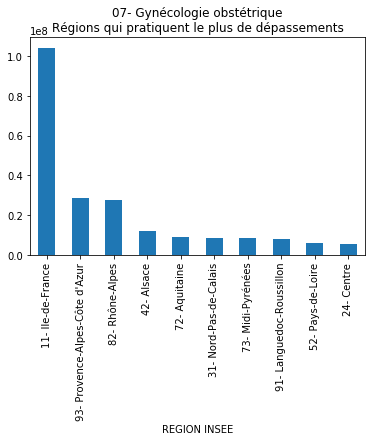

In [334]:
#07- Gynécologie obstétrique
spec = "07- Gynécologie obstétrique"
dep_P = df_spe_hono[df_spe_hono['Spécialistes']==spec]
depBySpeP = dep_P.groupby(['REGION INSEE'])['DEPASSEMENTS (Euros)'].sum()
depBySpeP.sort_values(inplace=True, ascending=False)
depBySpeP[depBySpeP != 0][:10].plot.bar(title=spec+'\nRégions qui pratiquent le plus de dépassements')

### Généralistes

In [321]:
df_gen_hono = xl.parse("Généralistes et MEP")
df_gen_hono.head()
df_gen_hono.columns
df_gen_hono['Généralistes et compétences MEP'].unique()


array(['01- Médecine générale', '01- M.E.P.', '01- OMNIPRATICIENS',
       '01- Acupuncture', '02- Homéopathie',
       '03- Thermalisme (hydrologie, cures climatiques)',
       '04- Allergologie', '05- Angiologie', '06- Médecine physique',
       '07- Phoniatrie', '08- Echotomographie', "09- Médecine d'urgence",
       '10- Médecine Légale', '40- Audiométrie',
       '41- Acupuncture et Médecine Générale',
       '42- Allergologie et Médecine Générale',
       '43- Anesthésie-réanimation', '44- Angiologie et Médecine Générale',
       '45- Biologie', '46- Carcinologie', '47- Cardiologie',
       '48- Chirurgie esthétique', '49- Chirurgie générale',
       '50- Chirurgie maxillo-faciale', '51- Chirurgie vasculaire',
       '52- Dermatologie et maladies vénériennes',
       '53- Electroencéphalographie et électromyographie',
       '54- Electroradiologie', '55- Endocrinologie et métabolisme',
       '56- Gastro-entérologie', '57- Gériatrie', '58- Gynécologie',
       '59- Hématologie', 

In [ ]:
import glob
glob.glob("/Users/very/Documents/MP/INFMDI721/marie-ranchet/Lesson5/*.csv")




In [ ]:
total_specialite_slicer = df['SPECIALITE'].str.upper().str.contains('TOTAL')
total_departement_slicer = df['DEPARTEMENT'].str.upper().str.contains('TOTAL')

df2 = df[~total_specialite_slicer & ~total_departement_slicer]

#df2['DEPARTEMENT'].str.split('-', 1)
df2['DEPARTEMENT'] = df2['DEPARTEMENT'].str.extract('([\dAB]+)-(.*)')[1]
df2['SPECIALITE'].str.split('-', 1).str.get(1)

df2 = df2.dropna(subset = ['CONVENTIONNES'])


In [ ]:
filename = "rpps-medecins-tab5_46230360875407.csv"
regions = pd.read_csv(filename, sep=';',  error_bad_lines=False, encoding = "ISO-8859-1")